Example of parameter uncertainties in fits
=====

First we generate random data to fill a histogram using the PDF for a normal distribution.

In [1]:
import ROOT as r
# make only static plots
%jsroot off  

In [2]:
h=r.TH1F("h1","Random normal;x;#events",100,-4,4)
h.Sumw2()  # for error bars (and proper errors if using weighted data)
# here we use a custom function instead of the built in one to show the work more explicitly
gaus=r.TF1("mygaus","[0]*exp(-(x-[1])*(x-[1])/[2]/[2])",-4,4)
gaus.SetParameters(1,0,1)
h.FillRandom("gaus",4000)

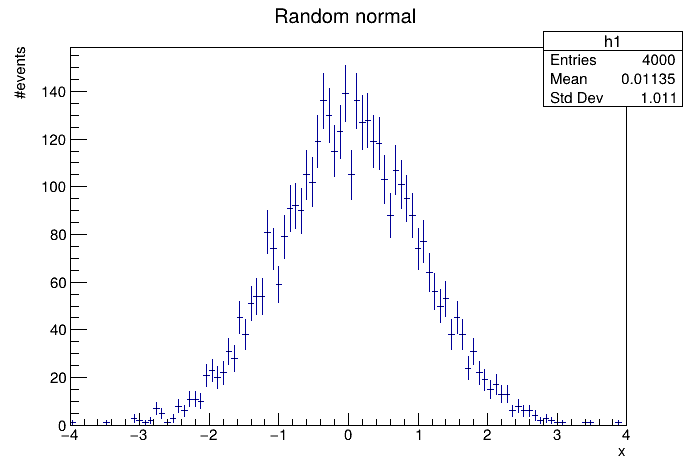

In [3]:
tc=r.TCanvas()
h.Draw()
tc.Draw()

Now we fit the data using a Gaussian.  (We'll discuss the fitting interface in ROOT in more detail later).

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      64.0783
NDf                       =           80
Edm                       =  1.89565e-11
NCalls                    =           82
Constant                  =      126.246   +/-   2.47579     
Mean                      =    0.0236443   +/-   0.0160279   
Sigma                     =      1.40923   +/-   0.01635     


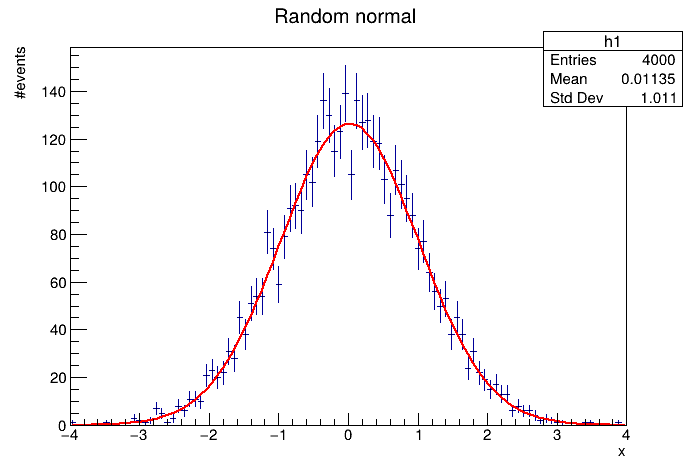

In [4]:
tc=r.TCanvas()
gaus.SetParameter(0,h.GetMaximum())  # adjust starting parameter
gaus.SetParName(0,"Constant");
gaus.SetParName(1,"Mean");
gaus.SetParName(2,"Sigma");
h.Fit("mygaus")
tc.Draw()
par=[0]*3
err=[0]*3
for i in range(3):
    par[i]=gaus.GetParameter(i)
    err[i]=gaus.GetParError(i)
chi2_fit=gaus.GetChisquare();

Notice that the fitter provided the best fit values as well as an estimate of the parameter uncertainty.  Try changing the number of entries generated for the histogram.  You will see the parameter (relative) errors shrinking or increasing if more or fewer data are generated.  Larger data sets constrain models better! 

Next, let's get a feeling for where these parameter errors are coming from.  We'll look at parameter(1), the fitted mean.

In [5]:
# Generate a range of values around the best fit value
import numpy as np
vals=np.linspace(par[1]-3*err[1],par[1]+3*err[1],100)

In [6]:
# for each value or the mean we minimize the other parameters, keeping the mean fixed
gaus.FixParameter(1,0)
grb=r.TGraph()
grb.SetTitle("Chi^2 vs param [1];param [1];Chi^2")
for b in vals:
    gaus.SetParameter(1,b)
    h.Fit("mygaus","q0")
    grb.SetPoint(grb.GetN(),b,gaus.GetChisquare())
gaus.ReleaseParameter(1)

Draw the contour of $\chi^2$ values, showing the dependence on the mean, eg $\chi^2(par[1];par[0],par[2])$.  We see that the $\chi^2$ has a parabolic shape to a large degree in the vicinity of the minimum.

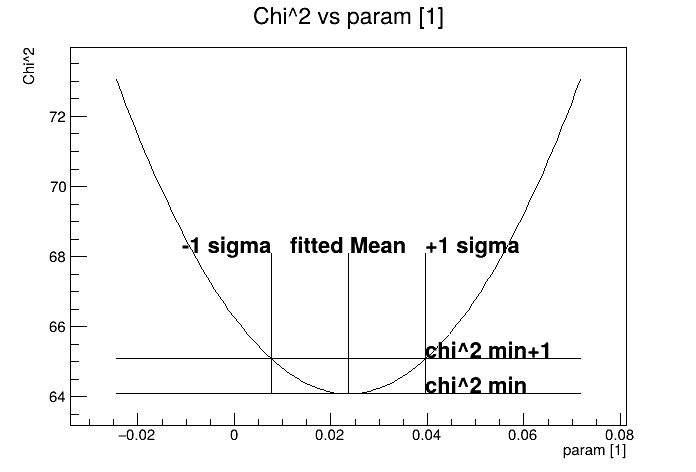

In [7]:
tc.Clear()
grb.Draw("al")
min=r.TLine(vals[0],chi2_fit,vals[-1],chi2_fit)
minplus1=r.TLine(vals[0],chi2_fit+1,vals[-1],chi2_fit+1)
nom1=r.TLine(par[1],chi2_fit,par[1],chi2_fit+4)
nom1minus=r.TLine(par[1]-err[1],chi2_fit,par[1]-err[1],chi2_fit+4)
nom1plus=r.TLine(par[1]+err[1],chi2_fit,par[1]+err[1],chi2_fit+4)

# Alignment options, see TAttText Class Reference
left=11
center=21
right=31
txt=r.TText()
txt.SetTextAlign(center);
txt.DrawText(par[1],chi2_fit+4,"fitted Mean")
txt.SetTextAlign(right);
txt.DrawText(par[1]-err[1],chi2_fit+4,"-1 sigma")
txt.SetTextAlign(left);
txt.DrawText(par[1]+err[1],chi2_fit+4,"+1 sigma")
txt.DrawText(par[1]+err[1],chi2_fit,"chi^2 min")
txt.DrawText(par[1]+err[1],chi2_fit+1,"chi^2 min+1")
min.Draw()
minplus1.Draw()
nom1.Draw()
nom1minus.Draw()
nom1plus.Draw()
tc.Draw()

Here we fit the region around the minimum to illustrate the parabolic shape. 

****************************************
Minimizer is Linear / Migrad
Chi2                      =  7.06168e-08
NDf                       =           31
p0                        =      66.2538   +/-   5.20695e-05 
p1                        =     -184.029   +/-   0.00484786  
p2                        =      3891.84   +/-   0.100895    


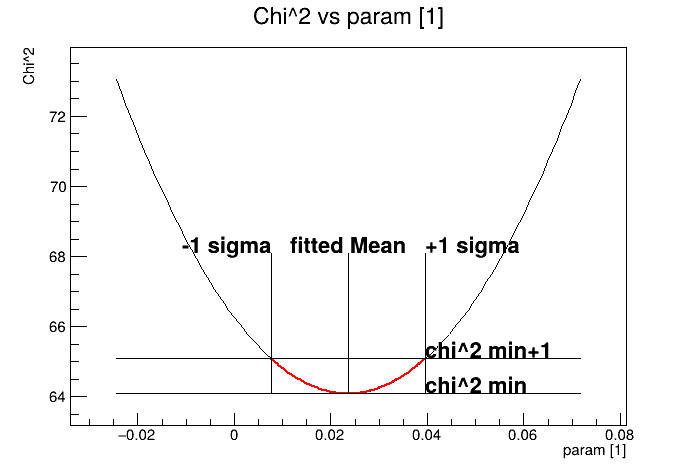

In [8]:
from math import sqrt
grb.Fit("pol2","","",par[1]-err[1],par[1]+err[1])
tc.Draw()

Using the curvture at the $\chi^2$ minimum, calculate the (parabolic) uncertainty on the mean.  This is the amount of variation needed to go from the $\chi^2$ minimum to $\chi^2$ minimum + 1.

In [9]:
pol2=grb.GetFunction("pol2")
d2X2d2p=pol2.GetParameter(2)*2
dx=sqrt(2/d2X2d2p)
print(f"Fitted error for param[1]:                                       {err[1]:.{4}}")
print(f"Error calculated from this 2nd derivative of chi^2 wrt param[1]: {dx:.{4}}")

Fitted error for param[1]:                                       0.01603
Error calculated from this 2nd derivative of chi^2 wrt param[1]: 0.01603


We see here that the parameter error quoted in the fit is directly related to the (parabolic) curvature of the chi^2 around the minimum.  The range of values of the parameter satisfying $\chi^2<\chi^2_{min}+1$ defines the "1-sigma" uncertainty of the fit parameter.

If this is a good estimation of the parameter uncertainty, how would you expect the fit parameters to vary if we repeated this fitting experiment many times on independently generated data samples?

**You will explore this question in this week's exercise!**

Fitting samples with low statistics
=====

Below is a recreation of the histogram in the class notes.

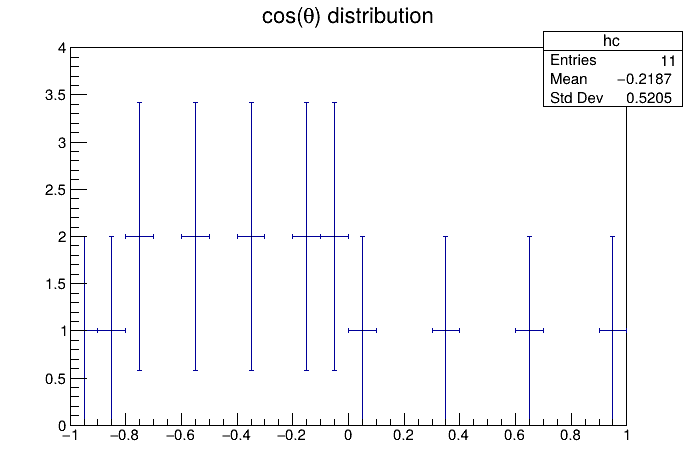

In [10]:
hc=r.TH1F("hc","cos(#theta) distribution",20,-1.,1)
hc.SetBinContent(1,1)
hc.SetBinError(1,1)
hc.SetBinContent(2,1)
hc.SetBinError(2,1)
hc.SetBinContent(3,2)
hc.SetBinError(3,sqrt(2))
hc.SetBinContent(5,2)
hc.SetBinError(5,sqrt(2))
hc.SetBinContent(7,2)
hc.SetBinError(7,sqrt(2))
hc.SetBinContent(9,2)
hc.SetBinError(9,sqrt(2))
hc.SetBinContent(10,2)
hc.SetBinError(10,sqrt(2))
hc.SetBinContent(11,1)
hc.SetBinError(11,1)
hc.SetBinContent(14,1)
hc.SetBinError(14,1)
hc.SetBinContent(17,1)
hc.SetBinError(17,1)
hc.SetBinContent(20,1)
hc.SetBinError(20,1)
hc.SetMaximum(4)
hc.Draw("e1")
tc.Draw()

Next we overlay a model similar to the one in the notes.

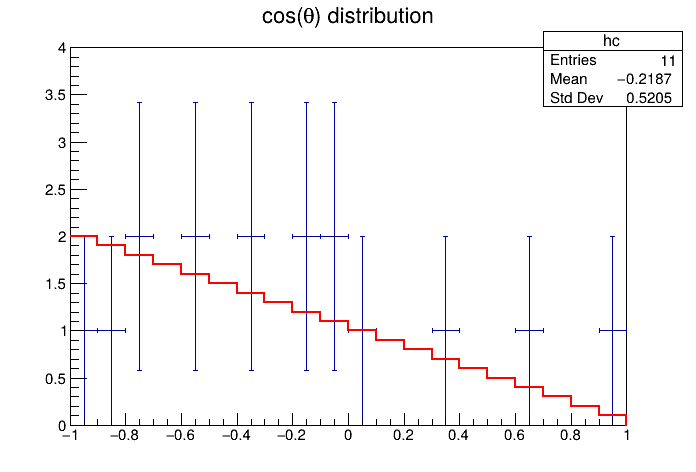

In [11]:
pol1=r.TF1("mypol1","[0]+[1]*x",-1,1)
pol1.SetParameters(1.05,-1)
pol1.SetNpx(20)
hc.Draw("e1")
pol1.GetHistogram().Draw("same")
tc.Draw()

In [12]:
from math import exp, factorial, log

# Poisson probability calculation, probability of n given mu
def Pnmu(n,mu):
    return mu**n * exp(-mu) / factorial(n)

# the NEGATIVE log(likelihood) for the Poisson distribution = -log(Pnmu(n,mu))
def NLL(n,mu):
    return log(factorial(n)) + mu - n*log(mu)

likelihood=1
nll=0
for ibin in np.arange(1,hc.GetNbinsX()+1):
    ibin=int(ibin)
    n=int(hc.GetBinContent(ibin))
    mu=pol1.Eval(hc.GetBinCenter(ibin))
    likelihood = likelihood * Pnmu(n,mu)  # joint probability for all data points wrt model
    nll=nll+NLL(n,mu)                     # NLL = -log(likelihood)
print(f"Likelihood = {likelihood}, NLL = {nll}")
nll_obs=nll # save for later

Likelihood = 7.141615082445676e-11, NLL = 23.36249707013963


Generation of pseudo experiments (PEs) to evaluate the quality of agreement represented by NLL=-23.4
Here we essentially use the model to define a Poisson mean in each bin of the histogram.  Then we randomly choose the bin contents based on this Poisson PDF.  

In [13]:
# generate a pseudo experiment based on our model (eg a theory or fit result)
# return the NLL for the PE
tr=r.TRandom3()
def getPE(h,fcn):
    nll=0
    for ibin in np.arange(1,h.GetNbinsX()+1):
        ibin=int(ibin)
        mu=fcn.Eval(h.GetBinCenter(ibin))
        n=tr.Poisson(mu)
        h.SetBinContent(ibin,n)
        h.SetBinError(ibin,sqrt(n))
        nll=nll+NLL(n,mu)
    return nll,h

NLL value for this PE: 22.59308602133566


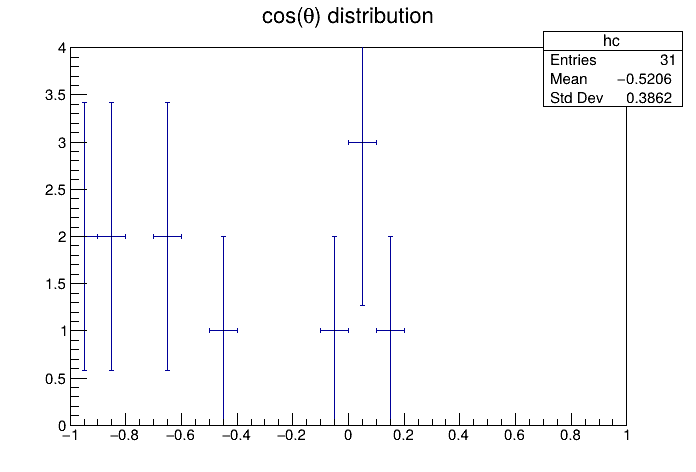

In [14]:
# here is an example of a PE
nll,h=getPE(hc,pol1)
h.Draw('e1')
tc.Draw()
print(f"NLL value for this PE: {nll}")

Here we perform many PEs and plot the distribution of the NLLs.  Notice how the NLL for our original data set wrt to the model compares to the distribution.  We would interpret this in a similar way to a p-value $\approx 0.5$.

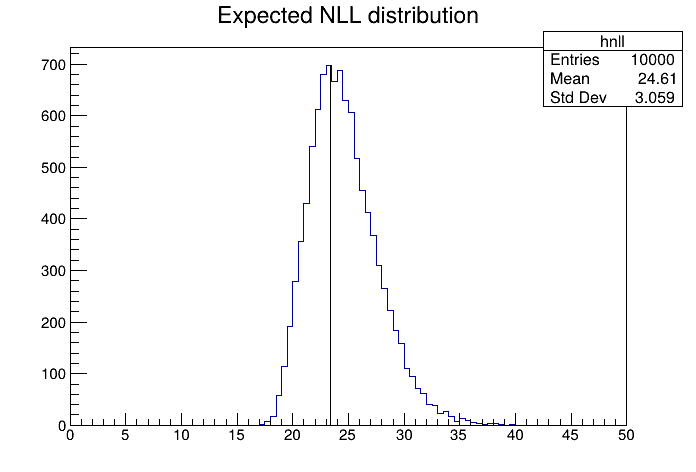

In [15]:
hnll=r.TH1F("hnll","Expected NLL distribution",100,0,50)
nexp=10000
for i in range(nexp):
    hnll.Fill(getPE(hc,pol1)[0])
hnll.Draw()
lobs=r.TLine(nll_obs,0,nll_obs,hnll.GetMaximum())
lobs.Draw()
tc.Draw()

The pseudo experiments to the RIGHT of the observed NLL in the distribution represent LOWER probability outcomes.  And those to the LEFT represent HIGHER probability outcomes.  Integrating above the line gives us a measure similar to a p-value in the $\chi^2$ fits. 